In [15]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:75% !important; }</style>"))

import os
import sys
import json
import datetime
import numpy as np
import pandas as pd
import json
import random
import shutil
import imgaug as ia
import imgaug.augmenters as iaa
import skimage
from skimage.morphology import label
from skimage.io import imread, imshow, concatenate_images
from skimage import color

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline
import cv2

import tensorflow as tf

from tqdm.notebook import tqdm
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from datetime import datetime

# Root directory of the project
ROOT_DIR = os.path.abspath("../../")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn.config import Config
from mrcnn import model as modellib, utils
from mrcnn.model import log
from mrcnn import visualize

# Path to trained weights file
COCO_WEIGHTS_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")

# Directory to save logs and model checkpoints, if not provided
# through the command line argument --logs
DEFAULT_LOGS_DIR = os.path.join(ROOT_DIR, "logs")


In [3]:
# IMPORTANT: Run this to limit GPU memory usage by tensorflow (causes Xserver crashes otherwise)
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)

## Notebook Preferences

In [4]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

############################################################
#  Configurations
############################################################

In [5]:
# Global variables
DATASET_DIR    = '../../data/FashionDataSet/'
SPLIT_TRAIN_DIR = os.path.join(DATASET_DIR, 'split_train' )
SPLIT_VAL_DIR = os.path.join(DATASET_DIR, 'split_val' )
LABELS_INFO_FILE    = os.path.join(DATASET_DIR, 'label_descriptions.json' )
RUN_ID = datetime.now().strftime('%Y%m-%d%H-%M%S')
WEIGHTS_DIR = os.path.join(DATASET_DIR, "weights", RUN_ID)    
WEIGHTS_FILE_PATH =  os.path.join(WEIGHTS_DIR, "mask_rcnn_imaterialist.h5")
HISTORY_FILE_PATH =  os.path.join(WEIGHTS_DIR, "history.json")

In [20]:
class FashionConfig(Config):
    """
    Configuration for training on the fashion dataset.
    Derives from the base Config class and overrides values specific
    to the fashion dataset.
    """
    # Give the configuration a recognizable name
    NAME = "fashion"
    
    # Set backbone to resnet50
    BACKBONE = 'resnet50'
    
    # Train on 1 GPU and 8 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 8 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 2 #can change this

    # Number of classes (including background)
    NUM_CLASSES = 1 + 46  # background + 46 fashion categories

############################################################
#  Dataset
############################################################

In [11]:
class FashionDataset(utils.Dataset):
    
    @staticmethod
    def load(filepath:str):
        with open(filepath, 'rb') as f:
            data = pickle.load(f)
            return data
        
    def save(self, filepath:str):
        with open(save_file, 'wb') as f:
            pickle.dump(self, filepath)
            
    def __len__(self):
        return len(self.image_info)
    
    def __init__(self):
        super(FashionDataset, self).__init__()  
        self.class_names= []
    
    def create_classes(self, cat_file:str) -> [dict]:
        """
        Added to FashionDataset.
        Initialize the classes.
        param:cat_file - filepath to fashion dataset's label_descriptions.json file
        """
        # read labels file
        with open(cat_file, 'r') as data_file:
            data=data_file.read()

        # parse file
        labels = json.loads(data)

        categories = labels.get('categories')
        df_categories = pd.DataFrame(categories)
        df_categories['source'] = "imaterialist"

        dict_categories = [dict(x[1]) for x in df_categories.iterrows()]

        for c in dict_categories:
            self.add_class(c['source'], c['id']+1, c['name']) # add 1 to make room for background

        print ("{} classes added.".format(len(dict_categories)))

        return dict_categories
    
    
    def create_anns(self, sub_df_images:pd.DataFrame) -> dict:
        """
        Creates an 'annotations' entry in an image's image_info entry.
        dict_keys(['id', 'image_id', 'segmentation', 'category_id', 'area', 'iscrowd', 'bbox']
        """
        annotations = []
        
        for mask in sub_df_images.iterrows():
            h      = int(mask[1].Height)
            w      = int(mask[1].Width)
            counts = np.fromstring(mask[1].EncodedPixels, dtype=int, sep=" ")
            ann_dict = {'id'            : mask[0], 
                        'image_id'      : mask[1].ImageId, 
                        'segmentation'  : {'counts' : counts, 'size': [h, w] }, 
                        'category_id'   : int(mask[1].ClassId.split('_')[0])+1, # add 1 to make room for background
                        'iscrowd'       : True, # True indicates the use of uncompressed RLE
                        'bbox'          : [] }

            annotations.append(ann_dict)
            
        return annotations
        
    
    def create_images(self, images_file:str, train_dir:str, imgids:list=None, limit:int=None) -> (dict, pd.DataFrame):
        """
        Build the image_info['images'] dictionary element with all images.
        If imgids list is None, all images in the images_file will be included, otherwise,
        only the imgids in the list will be included.
        """
        
        df_images = pd.read_csv(images_file, nrows=limit)
        
        # restrict the dataframe to items in imgids list, if list is provided
        if imgids is not None:
            df_images = df_images[df_images.ImageId.isin(imgids)]
        
        
        
#         df_images.rename(columns={"ImageId":'file_name', "Height":'height', "Width":'width'}, inplace=True)
#         df_images['id'] = [x for x in range(len(df_images))]
#         df_images['source'] = 'imaterialist'
        
        df_images_unique = df_images.drop_duplicates('ImageId')
#         dict_images = [dict(x[1]) for x in tqdm(df_images_unique.iterrows(), desc="Create images dict", total=len(df_images))]
        
        
        for image in tqdm(df_images_unique.iterrows(), desc="Add images to object"):
#         for image in tqdm(dict_images, desc="Add images to object"):
#             file_path = os.path.join(train_dir,image[1].ImageId)
            self.add_image(source       = 'imaterialist', 
                           image_id     = image[0],
                           path         = os.path.join(train_dir,image[1].ImageId), 
                           height       = image[1].Height,
                           width        = image[1].Width,
                           file_name    = image[1].ImageId,
                           annotations  = self.create_anns(df_images[df_images.ImageId==image[1].ImageId]))
            
        print("Added {} images.".format(len(df_images_unique)))
        print("Added {} annotations.".format(len(df_images)))

        return self.image_info
    
    
    def load_image(self, image_id):
        """
        Load the specified image and return a [H,W,3] Numpy array.
        """
        # Load image
        image = skimage.io.imread(self.image_info[image_id]['path'])
        # If grayscale. Convert to RGB for consistency.
        if image.ndim != 3:
            image = skimage.color.gray2rgb(image)
        # If has an alpha channel, remove it for consistency
        if image.shape[-1] == 4:
            image = image[..., :3]
        return image
    
    
    def load_mask(self, image_id):
        """Load instance masks for the given image.

        Different datasets use different ways to store masks. This
        function converts the different mask format to one format
        in the form of a bitmap [height, width, instances].

        Returns:
        masks: A bool array of shape [height, width, instance count] with
            one mask per instance.
        class_ids: a 1D array of class IDs of the instance masks.
        """
        
        image_info = self.image_info[image_id]

        instance_masks = []
        class_ids = []
        
        # returns list of masks/annotations for the image
        annotations = self.image_info[image_id]["annotations"] 
        
        # Build mask of shape [height, width, instance_count] and list
        # of class IDs that correspond to each channel of the mask.
        for annotation in annotations:
            class_id = annotation['category_id'] # one of 46 categories
            
            if class_id:
                # passes an element of the annotations list - this is a single mask entry
#                 m = self.annToMask(annotation, image_info["height"], image_info["width"])

                # updated to reflect problems with original maskutils implementtaion of decode
                m = self.kaggle_rle_decode(annotation, image_info["height"], image_info["width"])
                
                # Some objects are so small that they're less than 1 pixel area
                # and end up rounded out. Skip those objects.
                if m.max() < 1:
                    continue
                # Is it a crowd? If so, use a negative class ID.
                if annotation['iscrowd']:
                    # Use negative class ID for crowds
#                     class_id *= -1  # mark: not sure why this was done so commetning it out
                    # For crowd masks, annToMask() sometimes returns a mask
                    # smaller than the given dimensions. If so, resize it.
                    if m.shape[0] != image_info["height"] or m.shape[1] != image_info["width"]:
                        m = np.ones([image_info["height"], image_info["width"]], dtype=bool)
                instance_masks.append(m)
                class_ids.append(class_id)

        # Pack instance masks into an array
        if class_ids:
            mask = np.stack(instance_masks, axis=2).astype(np.bool)
            class_ids = np.array(class_ids, dtype=np.int32)
            return mask, class_ids
        

    def image_reference(self, image_id):
        """Return a link to the image in its source Website or details about
        the image that help looking it up or debugging it.
        Override for your dataset, but pass to this function
        if you encounter images not in your dataset.
        """
        # assume user provided the integer id of the image
        for img in self.image_info:
            if img['id'] == image_id:
                return img['path']

        # check if the user entered the file name
        for img in self.image_info:
            if img['file_name'] == image_id:
                return img['path']
        
        print ("Image '{}' not found.".format(image_id))
        return None

    
    def kaggle_rle_decode(self, ann, h, w):
        """
        https://github.com/amirassov/kaggle-imaterialist/blob/master/src/rle.py
        Takes uncompressed RLE for a single mask.  Returns binary mask.
        param: ann - annotation including uncompressed rle in ['segmentation']['counts'] 
        -- where counts is a list of integers.  Also includes 'size' which is a list [int(h), int(w)] 
        """
        rle = ann['segmentation']['counts']
        
        starts, lengths = map(np.asarray, (rle[::2], rle[1::2]))
        starts -= 1
        ends = starts + lengths
        img = np.zeros(h * w, dtype=np.uint8)
        for lo, hi in zip(starts, ends):
            img[lo:hi] = 1
        return img.reshape((w, h)).T

In [ ]:
def create_train_val_datasets(images_file:str, 
                              cat_file:str, 
                              split:float=0.8, 
                              limit:int=None) -> (FashionDataset,FashionDataset):
    """
    Returns a train and a val dataset object.
    If limit is None, all entries in file will be used as the population.
    """
    # split the train.csv file into train and val dataframes
    df_images = pd.read_csv(images_file, nrows=limit)
    
    # OPTN1: split so that some images will have some annotations in train and others in val
#     df_train, df_val = train_test_split(df_images , train_size=split)
    
    # OPTN2: split to that images' annotations are not in different sets
    image_filenames = np.unique(df_images.ImageId)
    train_imgids, val_imgids = train_test_split(image_filenames , train_size=.8)
    
    # Create empty objects
    fash_train = FashionDataset()
    fash_val = FashionDataset()
    
    # build classes in dataset objects
    train_classes = fash_train.create_classes(cat_file) # takes seconds
    val_classes   = fash_val.create_classes(cat_file)   # takes seconds
    
    # load image references and masks into dataset objects
    print("Building trainig dataset...")
    train_image_info = fash_train.create_images( images_file, train_dir, train_imgids, limit=limit) 
    print("Building validation dataset...")
    val_image_info   = fash_val.create_images(   images_file, train_dir, val_imgids,   limit=limit) 
    
    fash_train.prepare()
    fash_val.prepare()
    
    return fash_train, fash_val

In [7]:
def train(model, config, dataset_train, dataset_val):
    """Train the model."""
    print("Training network heads")
    model.train(dataset_train, dataset_val,
                learning_rate=config.LEARNING_RATE,
                epochs=20,
                layers='heads')

In [8]:
import pickle

# Use pickle to save history for later use
def pickle_save(variable, save_dir, pickel_fileName):
#     cwd = os.getcwd()
#     Save_dir = cwd + '//pickle//'
    save_file = save_dir + pickel_fileName
    if os.path.isdir(save_dir) == 0:
        os.mkdir(save_dir)
    with open(save_file, 'wb') as f:
        pickle.dump(variable, f)


# Loading a prevously saved pickle file
def pickle_load(save_dir, pickel_fileName):
#     cwd = os.getcwd()
#     pickle_file = cwd + '//pickle//' + pickel_fileName
    # Getting back the data:
    pickle_filepath = os.path.join(save_dir, pickel_fileName)
    with open(pickle_filepath, 'rb') as f:
        history = pickle.load(f)
        return history

In [32]:
def find_best(history, config, model_dir):
    minidx = np.argmin(history["val_loss"])
    # Get directory names. Each directory corresponds to a model
    dir_names = next(os.walk(MODEL_DIR))[1]
    key = config.NAME.lower()
    dir_names = filter(lambda f: f.startswith(key), dir_names)
    dir_names = sorted(dir_names)
    if not dir_names:
        import errno
        raise FileNotFoundError(
            errno.ENOENT,
            "Could not find model directory under {}".format(self.model_dir))

    # Pick last directory
    dir_name = os.path.join(MODEL_DIR, dir_names[-1])

    # Find the checkpoint based on index checkpoint
    checkpoints = next(os.walk(dir_name))[2]
    checkpoints = filter(lambda f: f.startswith("mask_rcnn"), checkpoints)
    checkpoints = sorted(checkpoints)
    if not checkpoints:
        import errno
        raise FileNotFoundError(
            errno.ENOENT, "Could not find weight files in {}".format(dir_name))
    elif minidx > len(checkpoints):
        raise Exception("Epoch index is greater than available checkpoints")
    checkpoint = os.path.join(dir_name, checkpoints[minidx])
    return history["val_loss"][minidx], checkpoint

In [43]:
# Utility functions
def generate_color_scheme(nclasses):
    return visualize.random_colors(nclasses, bright = True)

def plotImg(img, figsize=(12,6)):
    plt.figure(figsize=figsize)
    plt.imshow(img), plt.grid(False)
    plt.show()

def plotImgSideBySide(img1, img2, figsize=(24,6), title1=None, title2=None):
    plt.figure(figsize=figsize)
    plt.subplot(121),plt.imshow(img1),plt.grid(False),plt.title(title1)
    plt.subplot(122),plt.imshow(img2),plt.grid(False),plt.title(title2)
    plt.show()
    
def plotImgSideBySideBySide(img1,img2,img3,figsize=(12,4),title1=None,title2=None,title3=None,save_bool=False,fn='result'):
    plt.figure(figsize=figsize)
    plt.subplot(131),plt.imshow(img1),plt.grid(False),plt.title(title1),plt.axis('off')
    plt.subplot(132),plt.imshow(img2),plt.grid(False),plt.title(title2),plt.axis('off')
    plt.subplot(133),plt.imshow(img3),plt.grid(False),plt.title(title3),plt.axis('off')
    if save_bool:
        plt.savefig(fn+'.jpg')
    plt.show()

def plotImgOverlay(img1, img2, figsize=(12,6)):
    plt.figure(figsize=figsize)
    plt.imshow(img1),plt.imshow(img2,alpha=0.6),plt.grid(False)
    plt.show()

def masksAsImage(masks, class_ids, color_scheme):
    combinedMask = np.zeros((masks.shape[0], masks.shape[1], 3)) # RGB Image
    for index, ids in enumerate(class_ids):
        combinedMask[masks[:,:,index]] = color_scheme[ids]
    return combinedMask

## Validate the dataset object by loading a subset of the images and visualizing the images with their masks

In [ ]:
# NOTE: There are 300k line images in the full training list
fash_train, fash_val = create_train_val_datasets( images_file, 
                                                  cat_file, 
                                                  split=0.8, 
                                                  limit=100000)

pickle_save(fash_train, data_dir, 'fashion_train_dataset_10k.pkl')
pickle_save(fash_val, data_dir, 'fashion_val_dataset_10k.pkl')

In [13]:
#Load FasionDataset Objects
# If you have saved the datasets, you can load them, it resplit and build them again
dataset_train = pickle_load(DATASET_DIR, 'fashion_train_dataset_10k.pkl')
dataset_val = pickle_load(DATASET_DIR, 'fashion_val_dataset_10k.pkl')

image_id  2138 ../../data/FashionDataSet/train/021af4001512419103e1b00d2d743878.jpg
image                    shape: (1000, 618, 3)        min:    0.00000  max:  255.00000  uint8
mask                     shape: (1000, 618, 8)        min:    0.00000  max:    1.00000  bool
class_ids                shape: (8,)                  min:    2.00000  max:   34.00000  int32
bbox                     shape: (8, 4)                min:   83.00000  max:  951.00000  int32


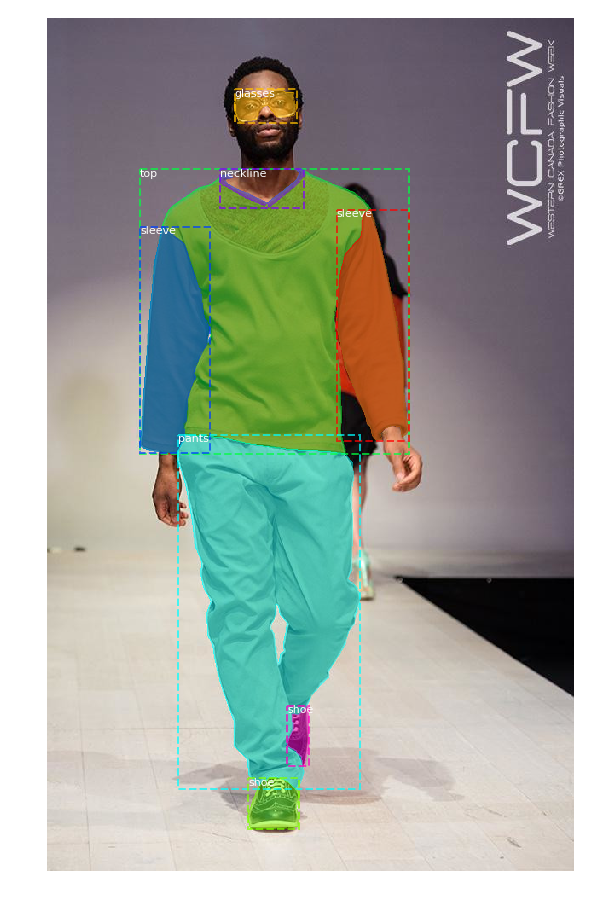

In [16]:
# Load random image and mask.
image_id = random.choice(dataset_train.image_ids)
image = dataset_train.load_image(image_id)
mask, class_ids = dataset_train.load_mask(image_id)
# Compute Bounding box
bbox = utils.extract_bboxes(mask)

# Display image and additional stats
print("image_id ", image_id, dataset_train.image_reference(image_id))
log("image", image)
log("mask", mask)
log("class_ids", class_ids)
log("bbox", bbox)
# Display image and instances
visualize.display_instances(image, bbox, mask, class_ids, dataset_train.class_names)

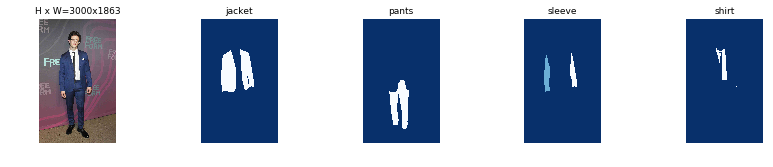

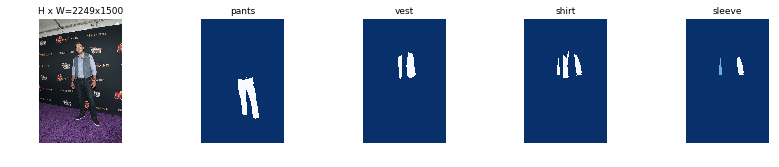

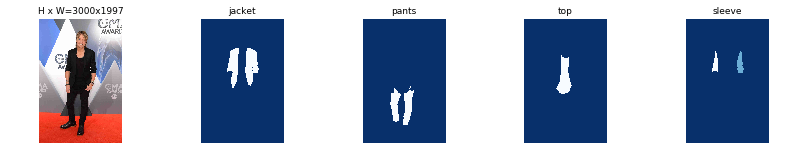

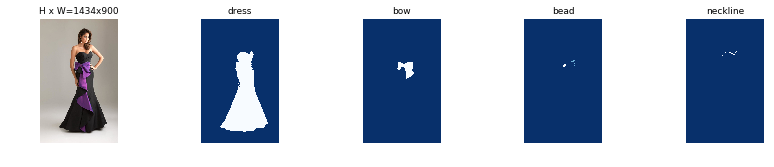

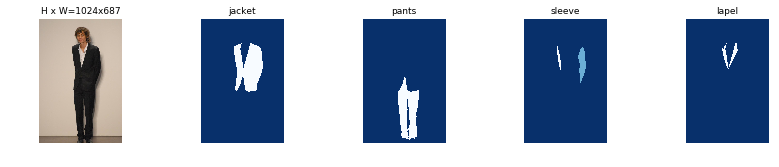

In [17]:
# Load and display random samples
image_ids = np.random.choice(dataset_train.image_ids, 5)
for image_id in image_ids:
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)

In [21]:
config = FashionConfig()
config.display()


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     2
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 2
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                59
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE          

In [22]:
# Directory to save logs and trained model
MODEL_DIR = os.path.join(DATASET_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(DATASET_DIR, "mask_rcnn_coco.h5")

# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

In [25]:
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)

# Exclude the last layers because they require a matching
# number of classes
model.load_weights(COCO_MODEL_PATH, by_name=True,
                   exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                            "mrcnn_bbox", "mrcnn_mask"])

Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead


## Training

Train in single stages:
1. Only the heads. Here we're freezing all the backbone layers and training only the randomly initialized layers (i.e. the ones that we didn't use pre-trained weights from MS COCO). To train only the head layers, pass `layers='heads'` to the `train()` function.

In [26]:
# Callbacks
callbacks = [
    EarlyStopping(patience=10, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001, verbose=1),
    ModelCheckpoint('mask_rcnn_imaterialist.h5', verbose=1, save_best_only=True, save_weights_only=True)
]

In [27]:
print("[INFO] Run ID: {}".format(RUN_ID))
print("[INFO] Training network heads")
model.train(dataset_train, dataset_val,
                    learning_rate=config.LEARNING_RATE,
                    epochs=1,
                    layers='heads',
                    custom_callbacks = callbacks,
                    augmentation = None)

history = model.keras_model.history.history

[INFO] Run ID: 201912-1522-1320
[INFO] Training network heads

Starting at epoch 0. LR=0.001

Checkpoint Path: ../../data/FashionDataSet/logs/fashion20191215T2220/mask_rcnn_fashion_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (

/opt/anaconda/anaconda3/envs/MaskRCNN-gpu/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:100: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/opt/anaconda/anaconda3/envs/MaskRCNN-gpu/lib/python3.6/site-packages/keras/engine/training.py:1987: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


Epoch 1/1
 999/1000 [============================>.] - ETA: 1s - loss: 2.9475 - rpn_class_loss: 0.1691 - rpn_bbox_loss: 1.1805 - mrcnn_class_loss: 0.6455 - mrcnn_bbox_loss: 0.4721 - mrcnn_mask_loss: 0.4803

/opt/anaconda/anaconda3/envs/MaskRCNN-gpu/lib/python3.6/site-packages/keras/engine/training.py:2142: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


Epoch 00000: val_loss improved from inf to 3.11445, saving model to mask_rcnn_imaterialist.h5
1000/1000 [==============================] - 1133s - loss: 2.9468 - rpn_class_loss: 0.1691 - rpn_bbox_loss: 1.1799 - mrcnn_class_loss: 0.6457 - mrcnn_bbox_loss: 0.4720 - mrcnn_mask_loss: 0.4802 - val_loss: 3.1144 - val_rpn_class_loss: 0.1970 - val_rpn_bbox_loss: 1.4513 - val_mrcnn_class_loss: 0.6575 - val_mrcnn_bbox_loss: 0.4342 - val_mrcnn_mask_loss: 0.3745


In [12]:
# In case of crashes use this code to recover the training history
#with open(HISTORY_FILE_PATH, 'r') as fp:
#    history = json.load(fp)

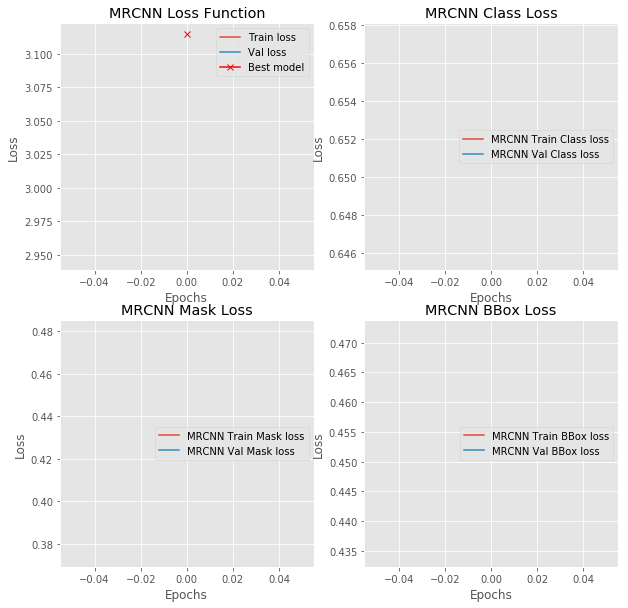

In [28]:
# plot loss
plt.figure(figsize=(10,10))

plt.subplot(221),plt.plot(history["loss"], label='Train loss'),
plt.plot(history["val_loss"], label='Val loss')
plt.plot(np.argmin(history["val_loss"]), np.min(history["val_loss"]), marker='x', color='r', label='Best model')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('MRCNN Loss Function')

plt.subplot(222),
plt.plot(history["mrcnn_class_loss"], label='MRCNN Train Class loss'),
plt.plot(history["val_mrcnn_class_loss"], label='MRCNN Val Class loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('MRCNN Class Loss')

plt.subplot(223),
plt.plot(history["mrcnn_mask_loss"], label='MRCNN Train Mask loss'),
plt.plot(history["val_mrcnn_mask_loss"], label='MRCNN Val Mask loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('MRCNN Mask Loss')

plt.subplot(224),
plt.plot(history["mrcnn_bbox_loss"], label='MRCNN Train BBox loss'),
plt.plot(history["val_mrcnn_bbox_loss"], label='MRCNN Val BBox loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('MRCNN BBox Loss')

plt.show()

In [33]:
loss, best_weights_path = find_best(history, config, MODEL_DIR)
print("[INFO] Best Model: {} (loss:{})".format(best_weights_path,loss))

if not os.path.isdir(WEIGHTS_DIR):
    os.makedirs(WEIGHTS_DIR)

if os.path.exists(WEIGHTS_FILE_PATH):
    print("[WARN] Model weights file already exists, file will be overwritten")
    
print("[INFO] Saving best model to '{}'".format(WEIGHTS_FILE_PATH))
shutil.copy(best_weights_path, WEIGHTS_FILE_PATH)

print("[INFO] Saving history to '{}'".format(HISTORY_FILE_PATH))
with open(HISTORY_FILE_PATH, 'w') as fp:
    json.dump(str(history), fp)

[INFO] Best Model: ../../data/FashionDataSet/logs/fashion20191215T2220/mask_rcnn_fashion_0000.h5 (loss:3.1144466018676757)
[INFO] Saving best model to '../../data/FashionDataSet/weights/201912-1522-1320/mask_rcnn_imaterialist.h5'
[INFO] Saving history to '../../data/FashionDataSet/weights/201912-1522-1320/history.json'


## Inference & Evaluation

In [34]:
class InferenceConfig(FashionConfig):
    # Set batch size to 1 since we'll be running inference on
    # one image at a time. Batch size = GPU_COUNT * IMAGES_PER_GPU
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    
    # Skip detections with < 70% confidence
    DETECTION_MIN_CONFIDENCE = 0.7

In [35]:
config = InferenceConfig()
config.display()


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                59
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE          

In [36]:
# Create model in inference mode
model = modellib.MaskRCNN(mode="inference", config=config,
                          model_dir=MODEL_DIR)
#weights_path = model.find_last()

# Load best weights for run
print("[INFO] Loading best weights for run ", WEIGHTS_FILE_PATH)
model.load_weights(WEIGHTS_FILE_PATH, by_name=True)

[INFO] Loading best weights for run  ../../data/FashionDataSet/weights/201912-1522-1320/mask_rcnn_imaterialist.h5


image ID: imaterialist.1294 (1294) ../../data/FashionDataSet/train/055a870e9d57da59260aca2b5c9b44a4.jpg
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 59)               min:    0.00000  max: 1024.00000  int64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
gt_class_id              shape: (15,)                 min:    1.00000  max:   43.00000  int32
gt_bbox                  shape: (15, 4)               min:   84.00000  max: 1023.00000  int32
gt_mask                  shape: (1024, 1024, 15)      min:    0.00000  max:    1.00000  bool


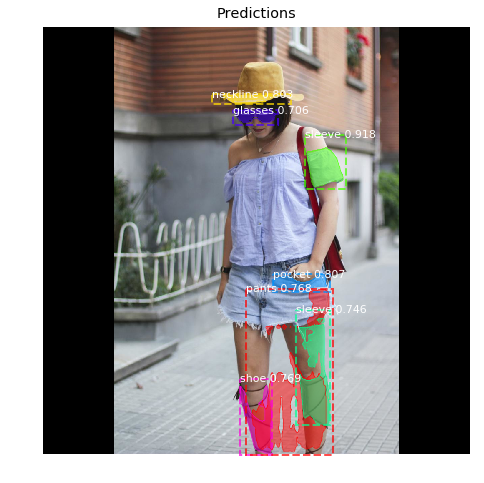

In [37]:
# Display single image with detections and boxes
image_id = random.choice(dataset_val.image_ids)
image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, config, image_id, use_mini_mask=False)
info = dataset_val.image_info[image_id]
print("image ID: {}.{} ({}) {}".format(info["source"], info["id"], image_id, 
                                       dataset_val.image_reference(image_id)))
# Run object detection
results = model.detect([image], verbose=1)

# Display results
ax = get_ax(1)
r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'], ax=ax,
                            title="Predictions")
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

image ID: imaterialist.1763 (1763) ../../data/FashionDataSet/train/06be049aead8c710143ef9bdf99fdc6d.jpg
Original image shape:  [3936 2110    3]
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  254.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min:    0.00000  max:  254.00000  uint8
image_metas              shape: (1, 59)               min:    0.00000  max: 3936.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
gt_class_id              shape: (13,)                 min:    2.00000  max:   36.00000  int32
gt_bbox                  shape: (13, 4)               min:  166.00000  max:  988.00000  int32
gt_mask                  shape: (1024, 1024, 13)      min:    0.00000  max:    1.00000  bool
AP @0.50:	 0.077
AP @0.55:	 0.077
AP @0.60:	 0.077
AP @0.65:	 0.077
AP @0.70:	 0.077
AP @0.75:	 0.000
AP @0.80:	 0.000
AP @0.85:	 0.000
AP @0.90:	 0.000
AP @0.95:	 0.000
AP @0

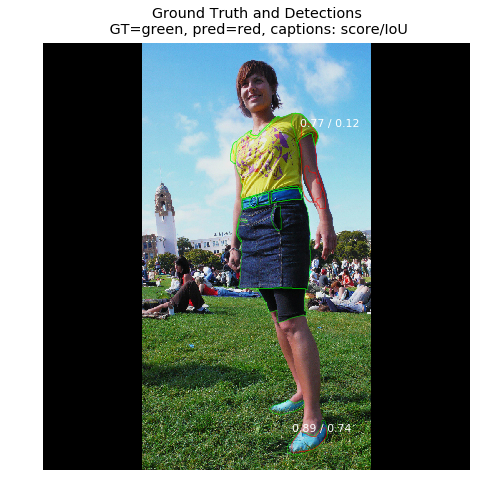

In [39]:
# Display single image with detections and boxes and ground truths
image_id = random.choice(dataset_val.image_ids)
image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, config, image_id, use_mini_mask=False)
info = dataset_val.image_info[image_id]
print("image ID: {}.{} ({}) {}".format(info["source"], info["id"], image_id, 
                                       dataset_val.image_reference(image_id)))
print("Original image shape: ", modellib.parse_image_meta(image_meta[np.newaxis,...])["original_image_shape"][0])

# Run object detection
results = model.detect_molded(np.expand_dims(image, 0), np.expand_dims(image_meta, 0), verbose=1)

# Display results
r = results[0]
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

# Compute AP over range 0.5 to 0.95 and print it
utils.compute_ap_range(gt_bbox, gt_class_id, gt_mask,
                       r['rois'], r['class_ids'], r['scores'], r['masks'],
                       verbose=1)

visualize.display_differences(
    image,
    gt_bbox, gt_class_id, gt_mask,
    r['rois'], r['class_ids'], r['scores'], r['masks'],
    dataset_val.class_names, ax=get_ax(),
    show_box=False, show_mask=False,
    iou_threshold=0.5, score_threshold=0.5)

## Precision-Recall (Use Image Above as Reference)## Precision-Recall

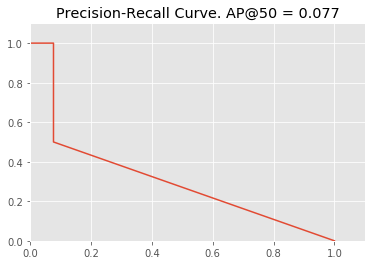

In [40]:
# Draw precision-recall curve
AP, precisions, recalls, overlaps = utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                                          r['rois'], r['class_ids'], r['scores'], r['masks'])
visualize.plot_precision_recall(AP, precisions, recalls)

## Confusion Matrix (Use Image Above as Reference)

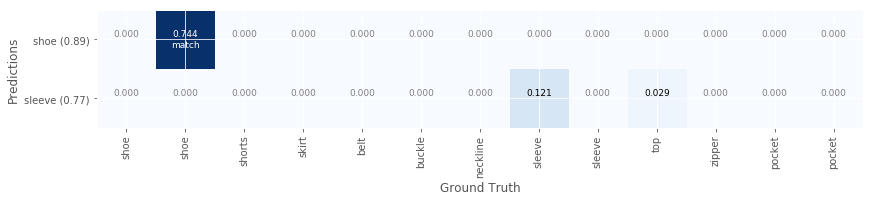

In [41]:
# Grid of ground truth objects and their predictions
visualize.plot_overlaps(gt_class_id, r['class_ids'], r['scores'],
                        overlaps, dataset_val.class_names)

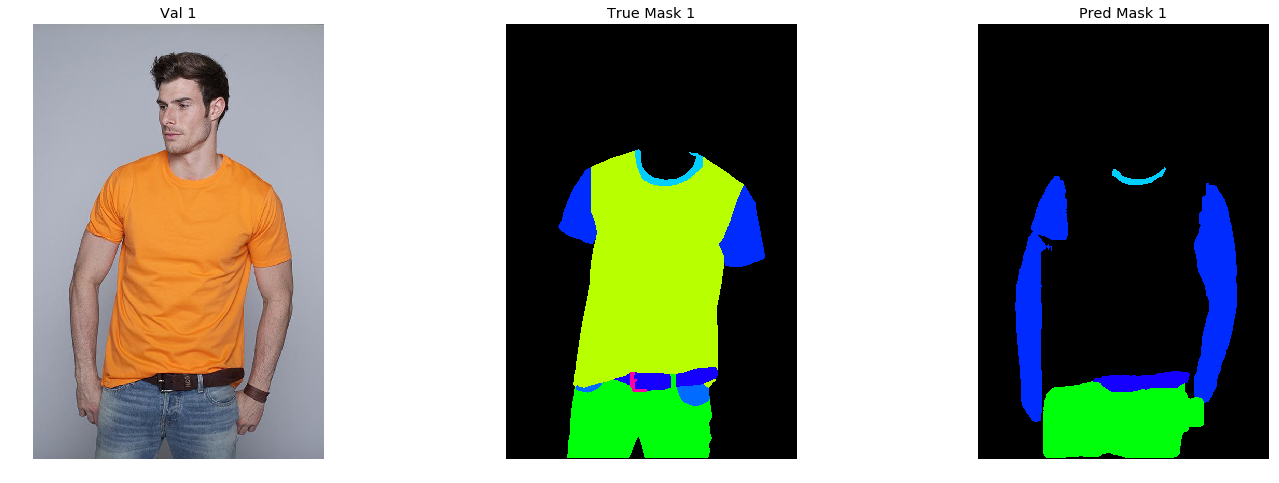

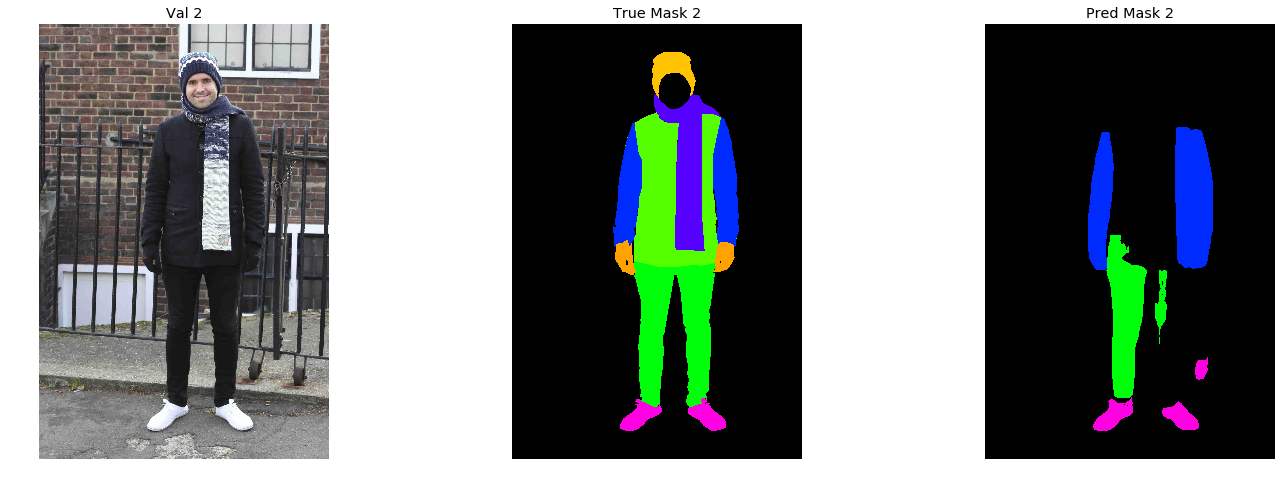

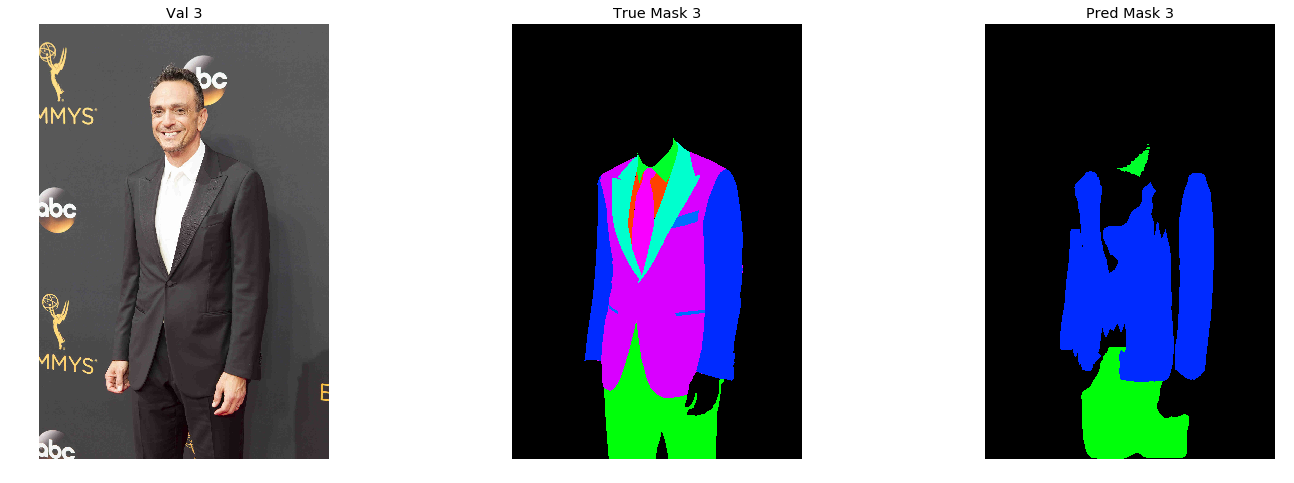

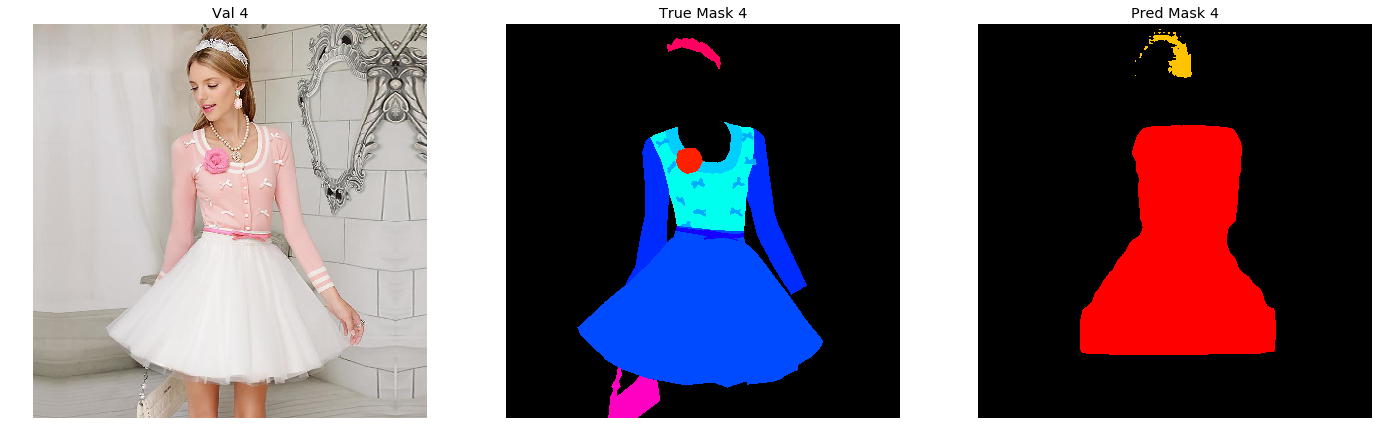

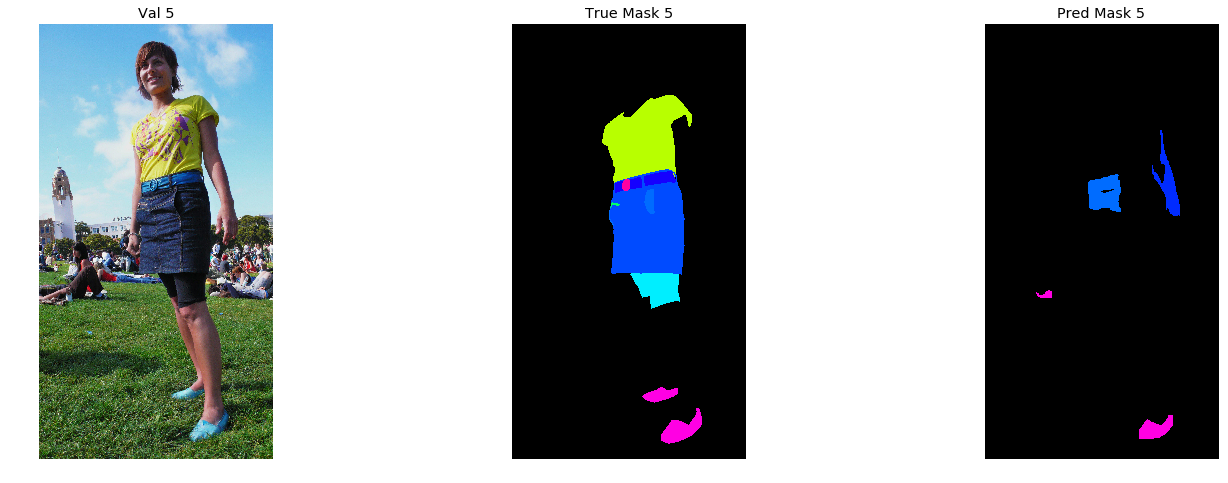

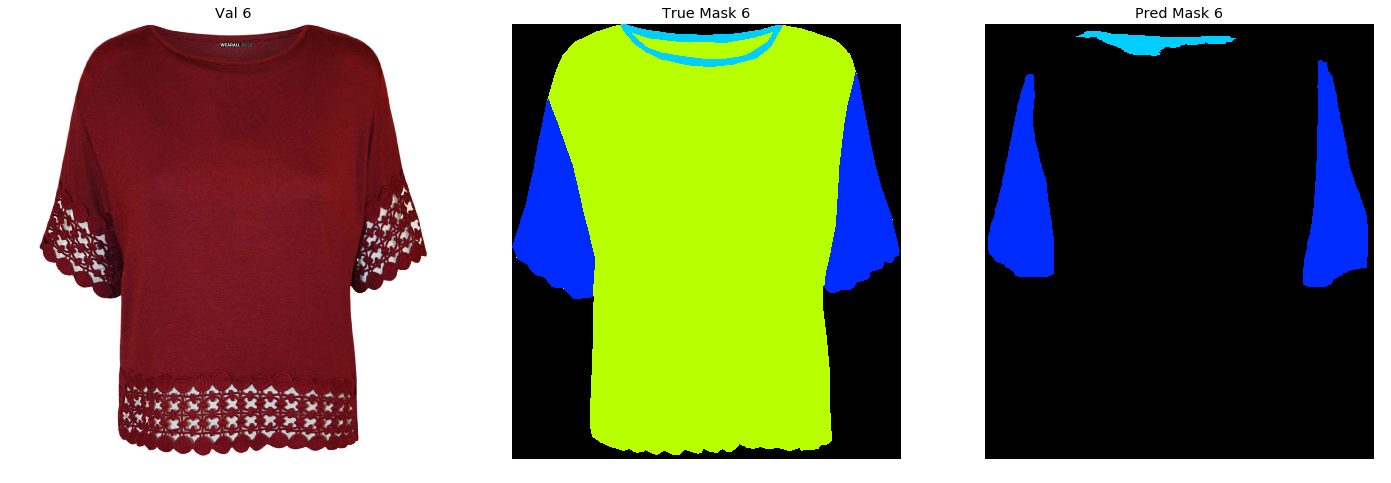

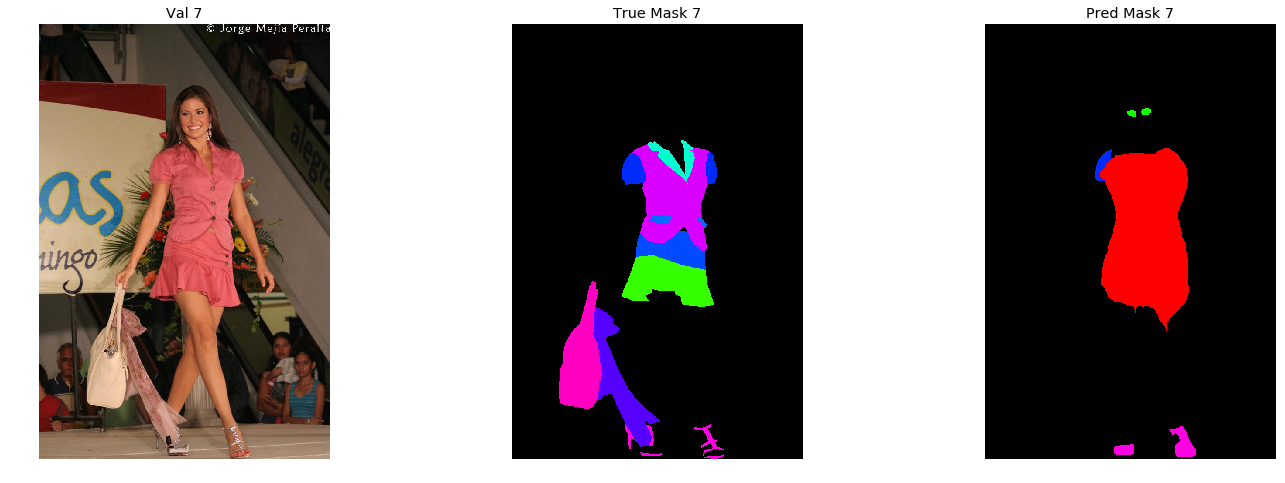

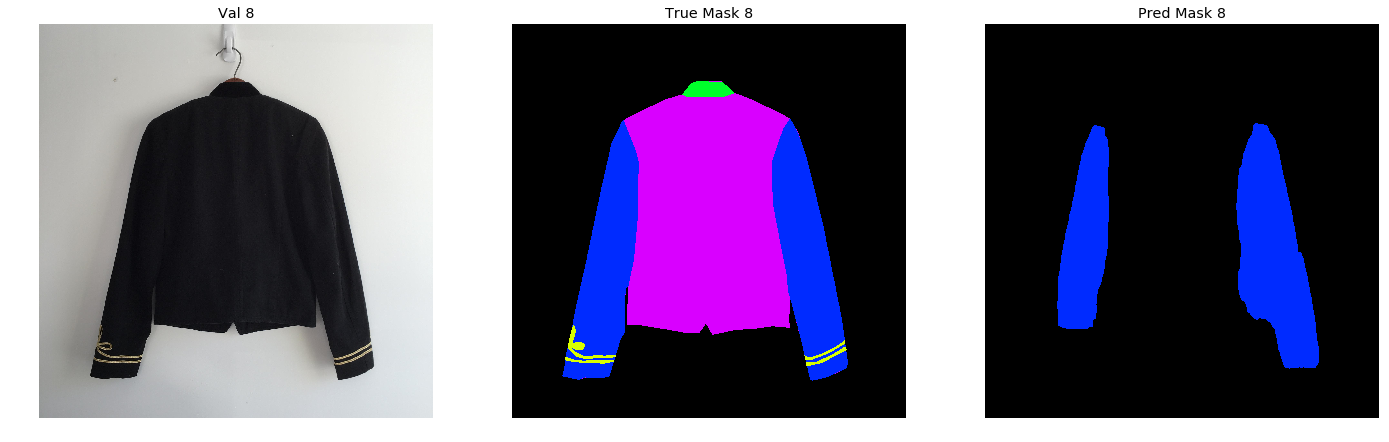

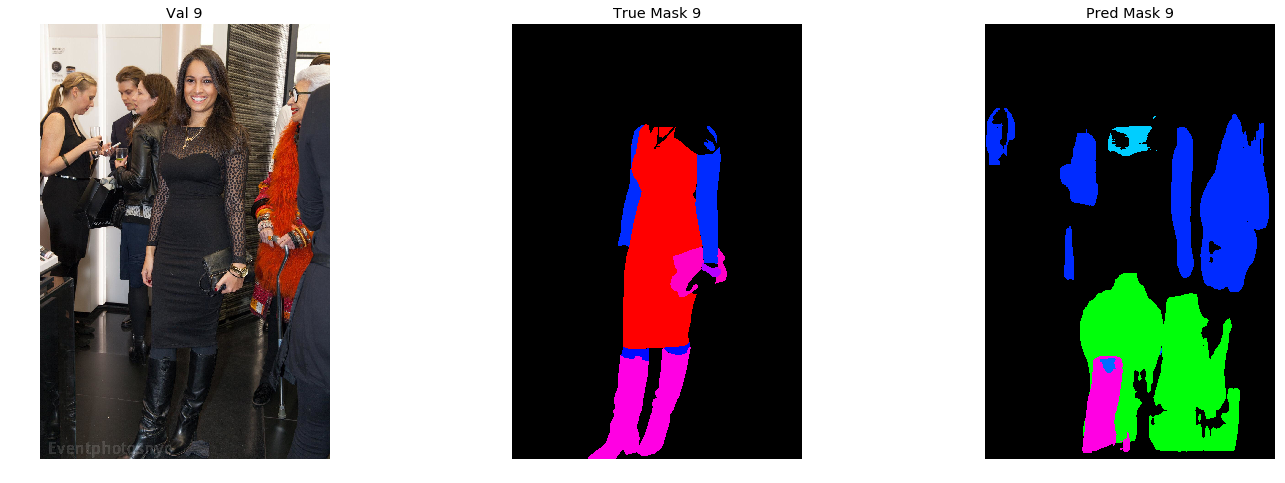

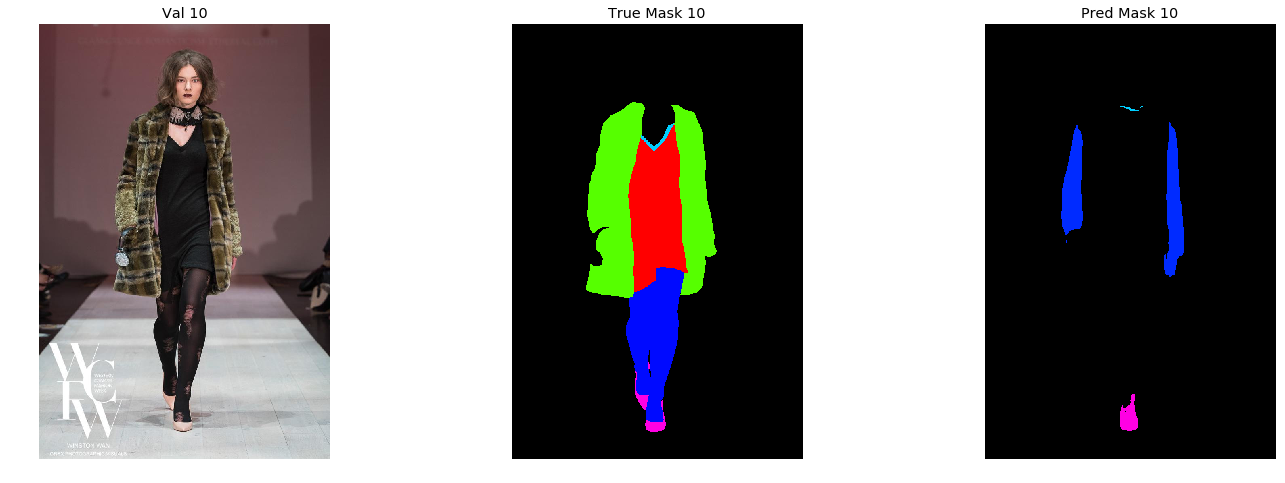

In [44]:
# Display several results
color_scheme = generate_color_scheme(len(dataset_val.class_names))

# Load and display random samples in Complete dataset
for i, image_id in enumerate(np.random.choice(dataset_val.image_ids, 10)):
    image = dataset_val.load_image(image_id)
    gt_masks, gt_class_ids = dataset_val.load_mask(image_id)
    
    # Run object detection
    results = model.detect([image], verbose=0)
    r = results[0]
    
    # Convert masks to images
    gt_mask_img = masksAsImage(gt_masks, gt_class_ids, color_scheme)
    pd_mask_img = masksAsImage(r['masks'], r['class_ids'], color_scheme)
    
    plotImgSideBySideBySide(image, gt_mask_img, pd_mask_img, (24,8),'Val '+str(i+1),'True Mask '+str(i+1),'Pred Mask '+str(i+1), True, './Figs/result_val_'+str(i+1))


/opt/anaconda/anaconda3/envs/MaskRCNN-gpu/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


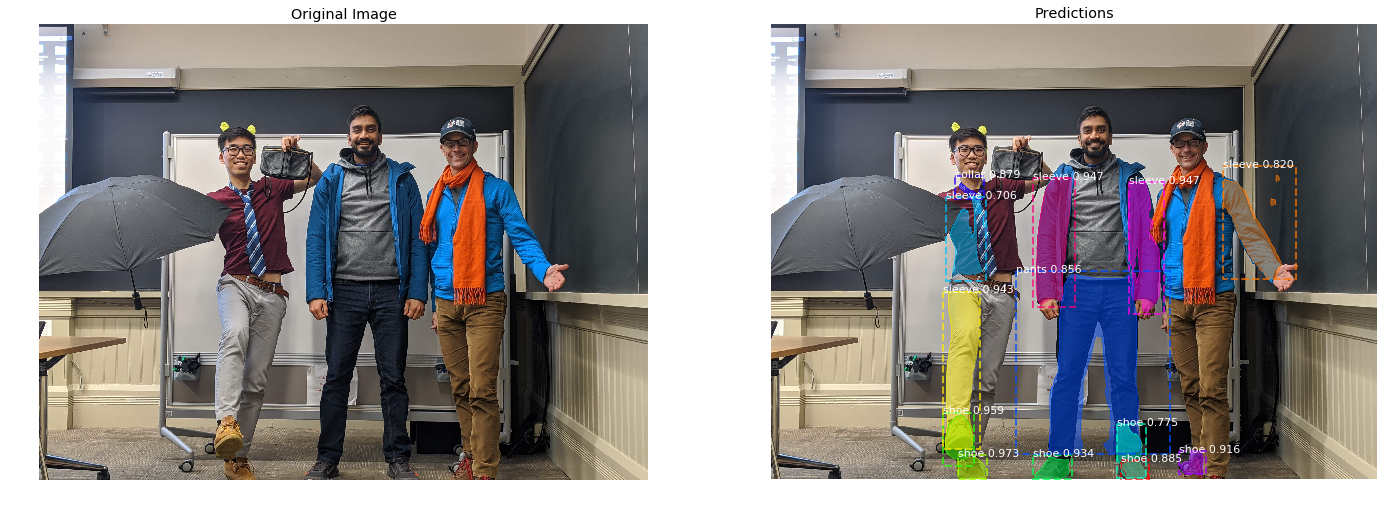

In [45]:
# Run detection on an image outside of the datasets
image = cv2.imread('./test/group.jpg', 1)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Run object detection
results = model.detect([image], verbose=0)
r = results[0]
    
# Display results
ax = get_ax(1,2,12)
ax[0].imshow(image)
ax[0].set_title('Original Image')
ax[0].axis('off')
ax[0].grid('off')
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'], ax=ax[1],
                            title="Predictions")

## Compute mAP @ IoU=50, IoU=0.75 and IoU=[0.5-0.95] on Batch of Images¶

In [46]:
def compute_batch_ap(dataset, image_ids, verbose=1):
    APs = []
    AP50s = []
    AP75s = []
    for image_id in image_ids:
        # Load image
        image, image_meta, gt_class_id, gt_bbox, gt_mask =\
            modellib.load_image_gt(dataset, config,
                                   image_id, use_mini_mask=False)
        # Run object detection
        results = model.detect_molded(image[np.newaxis], image_meta[np.newaxis], verbose=0)
        # Compute AP over range 0.5 to 0.95
        r = results[0]
        ap = utils.compute_ap_range(
            gt_bbox, gt_class_id, gt_mask,
            r['rois'], r['class_ids'], r['scores'], r['masks'],
            verbose=0)
        APs.append(ap)
        
        # Compute AP @ IoU = 50
        ap50, precisions, recalls, overlaps= utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                              r['rois'], r['class_ids'], r['scores'], r['masks'],
                            iou_threshold=0.5)
        AP50s.append(ap50)
        # Compute AP @ IoU = 75
        ap75, precisions, recalls, overlaps = utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                              r['rois'], r['class_ids'], r['scores'], r['masks'],
                            iou_threshold=0.75)
        AP75s.append(ap75)
        
        if verbose:
            info = dataset.image_info[image_id]
            meta = modellib.parse_image_meta(image_meta[np.newaxis,...])
            print("ID: {:3} W,H,C:{}, AP: {:.2f}, AP.50: {:.2f},AP.75: {:.2f}".format(
                meta["image_id"][0], meta["original_image_shape"][0], ap, ap50, ap75))
    return APs, AP50s, AP75s

# Run on 100 random images
limit = 100
APs, AP50s, AP75s = compute_batch_ap(dataset_val, dataset_val.image_ids[:limit], verbose = 0)
print("mAP @ IoU=50 for {} images: {}".format(limit, np.mean(AP50s)))
print("mAP @ IoU=75 for {} images: {}".format(limit, np.mean(AP75s)))
print("mAP @ IoU=[0.5..0.95] for {} images: {}".format(limit, np.mean(APs)))

mAP @ IoU=50 for 100 images: 0.20833333550890284
mAP @ IoU=75 for 100 images: 0.13222222278515497
mAP @ IoU=[0.5..0.95] for 100 images: 0.11958333421945574
